## Exercise on cross-correlation of real data

## Main Python packages used: 

- [**ObsPy**](https://github.com/obspy/obspy/wiki) : for downloading and basic analysis of seismic data

- [**NumPy**](https://numpy.org) : for mathematical functions

- [**Matplotlib**](https://matplotlib.org) : for plotting results

- [**SciPy**](https://github.com/obspy/obspy/wiki) : to compute [**cross-correlations**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html)

---


## Step 1: downloading data for two stations with the ObsPy FDSN web services

#### In this script in addition to being downloaded, the data are resampled (to reduce the size) and synchronized to simplify the interpretation of cross-correlations

---

### Possible examples of downloading data

---

### Cross-correlations during an eruption of the Piton de la Fournaise volcano
### 2 hours of data, HHZ channel, [**PF seismic network**](https://www.fdsn.org/networks/detail/PF/)
### possible stations: FJS, RVL, BON, HIM, FOR, RNL, VIL, HDL ... 


#### Some key python commands:
```python

#-------------------- defining duration of the downloaded time series in sec
t_duration =2*60*60
#------------ origin and location time of earthquake  -------
tstart = UTCDateTime("2017-07-13T20:40:00.000")        #  beginning of the July - August 2017 eruptiion 
tstart = UTCDateTime("2017-08-26T20:00:00.000")        #  later stge of the same eruption

sampling_rate = 20.
#------------------------ selecting an FDSN datacenter 
client = Client('RESIF')
#------------------------ selecting network, station, channel
ntw = "PF"
sta = "HIM"
chn = "HHZ"
signal1 = download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate)
print(signal1)

sta = "RVL"
signal2 = download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate)
print(signal2)

```
---
Map of the PF network highlighting 2 stations from the example the July 2017 eruption

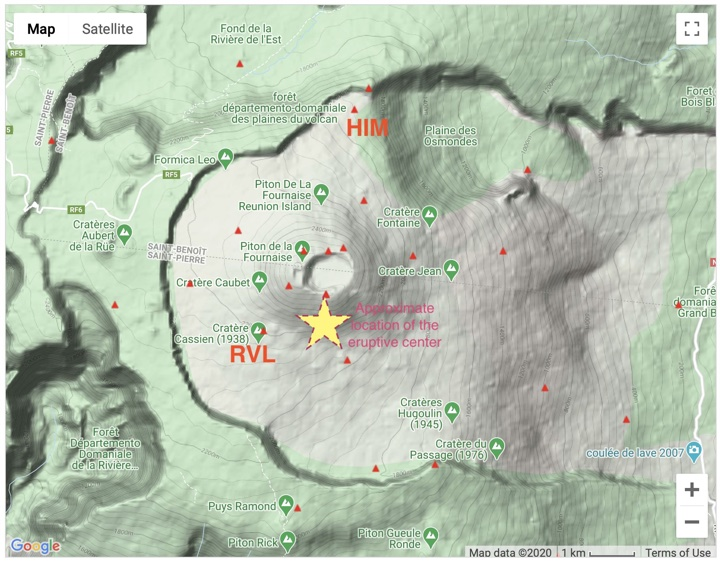

---


### 4 days of continuous records from two stations of South California Seismic Network
### LHZ channel (low sampling rate)

#### Some key python commands:
```python
#-------------------- defining duration of the downloaded time series in sec
t_duration =4*24*60*60
#------------ origin and location time of earthquake  -------
tstart = UTCDateTime("2018-03-09T20:00:00.000")        #  winter pattern

tstart = UTCDateTime("2018-07-19T20:00:00.000")        #  summer pattern 

tstart = UTCDateTime("2018-04-17T00:00:00.000")        #  spring pattern 

sampling_rate = 1.
#------------------------ selecting an FDSN datacenter 
client = Client('SCEDC')
#------------------------ selecting network, station, channel
ntw = "CI"
sta = "SMR"
chn = "LHZ"
signal1 = download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate)
print(signal1)

sta = "GRA"
signal2 = download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate)
print(signal2)

```
---


In [ ]:
#------------------------ importing basic packages
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
#------------------------ importing ObsPy functions
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

#------------------ plotting mode
%matplotlib widget
#----------------------------


#------------------------------------------------
# function to download a waveform and to resample it on exact starting time and nN of samples
#------------------------------------------------
def download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate):
    st = client.get_waveforms(ntw, sta, "*", chn, tstart-1, tstart + t_duration+1)
    print(st)
    sig = st[0]
    sig.detrend()
    sig.taper(.01)
    sig.filter("lowpass", freq=0.45*sampling_rate, corners=4, zerophase=True)
    npts = sig.stats.npts
    dt = sig.stats.delta
    npt_new =int(t_duration*sampling_rate)
    if npt_new > npts:
        npt_new = npts
    return sig.interpolate(sampling_rate,starttime=tstart, npts=npt_new)


#-------------------- defining duration of the downloaded time series in sec
t_duration =2*60*60
#------------ origin and location time of earthquake  -------
tstart = UTCDateTime("2017-07-13T20:40:00.000")        #  beginning of the July - August 2017 eruptiion 

sampling_rate = 20.
#------------------------ selecting an FDSN datacenter 
client = Client('RESIF')
#------------------------ selecting network, station, channel
ntw = "PF"
sta = "HIM"
chn = "HHZ"
signal1 = download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate)
print(signal1)

sta = "RVL"
signal2 = download_resample(tstart,t_duration,ntw,sta,chn,sampling_rate)
print(signal2)


---

## Step 2: preprocessing signals

### More information can be found in [Bensen et al. (2007)](https://drive.google.com/file/d/0B61PmiCvgooZUHFGRzZwMEFuSTQ/view) paper.

- **filtering** (ObsPy functions)

- **binarization** (*sbinarize* function is introduced)

---

## Step 3: computing and plotting cross-correlation

- [**correlate**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html) function from [**SciPy**](https://github.com/obspy/obspy/wiki)

---

In [ ]:
#------------------------ importing basic packages
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
#------------------------ importing ObsPy functions
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

#------------------ plotting mode
%matplotlib widget
#----------------------------



sig1 = signal1.copy()
sig2 = signal2.copy()

#-------------------- removeing long period noise
sig1.filter("highpass", freq=.01, corners=4, zerophase=True)
sig2.filter("highpass", freq=.01, corners=4, zerophase=True)

#------------- primary microseismic band
#sig1.filter("bandpass", freqmin=.04, freqmax=.09, corners=4, zerophase=True)
#sig2.filter("bandpass", freqmin=.04, freqmax=.09, corners=4, zerophase=True)

#------------- secondary microseismic band
#sig1.filter("bandpass", freqmin=.11, freqmax=.45, corners=4, zerophase=True)
#sig2.filter("bandpass", freqmin=.11, freqmax=.45, corners=4, zerophase=True)

#------------- volcanic tremor band
sig1.filter("bandpass", freqmin=1, freqmax=8, corners=4, zerophase=True)
sig2.filter("bandpass", freqmin=1, freqmax=8, corners=4, zerophase=True)


#---------------------  function to binarize signal
def sbinarize(signal):
#------------------------
    aaa = np.abs(signal)
    ma = max(aaa)
    aaa = aaa + 0.0001*ma
    signal = signal/aaa
    return signal

#sig1.data = sbinarize(sig1.data)
#sig2.data = sbinarize(sig2.data)




#------------------------
dt = 1./sampling_rate
npt = sig1.stats.npts

#----------------- signal time
t = np.arange(npt)
t = dt*t

#----------------- correlation time
tcc = np.arange(-(npt-1),npt)
tcc = dt*tcc

cc = signal.correlate(sig2.data,sig1.data,'full')/np.sqrt(np.sum(sig2.data**2)*np.sum(sig1.data**2))


#------------------------------------------------
# plotting signals
#..............................

plt.figure()

ax1 = plt.subplot(3,1,1)
ax1.plot(t,sig1.data,'r')
plt.title('signal at receiver 1')
#plt.xlim(0,300)

ax2 = plt.subplot(3,1,2)
ax2.plot(t,sig2.data,'b')
plt.title('signal at receiver 2')
#plt.xlim(0,300)

ax3 = plt.subplot(3,1,3)
ax3.plot(tcc,cc,'k')
plt.xlim(-40,40)
plt.title('cross-correlations between receivers 1 and 2')
plt.xlabel('time (s)')

plt.subplots_adjust(top=0.92, bottom=0.12, left=0.10, right=0.95, hspace=0.55, wspace=0.35)

plt.show()

